# Plot the Results
Plot the ternaries and binaries predicted using machine learning

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.spatial import ConvexHull
import numpy as np
import pandas as pd
import ternary
import json
import os

Variables to change

In [2]:
figure_width = 89 / 25.4
figure_height = figure_width * 0.7
colors = json.load(open(os.path.join('..', 'colors.json')))

## Plot the Ti-O Binary
The goal is to see how well the convex hull of the ML models agrees with reality

### Read the data

In [3]:
dft_data = pd.read_csv(os.path.join('datasets', 'Ti-O_test_set-fractions.csv'))

In [4]:
rf_fractions_data = pd.read_csv(os.path.join('model-outputs', 'RF_Ti-O_search-space-fractions.csv'))

In [5]:
rf_physical_data = pd.read_csv(os.path.join('model-outputs', 'RF_Ti-O_search-space-physical.csv'))
rf_physical_data = rf_physical_data.join(rf_fractions_data.drop('delta_e', 'columns'))
rf_physical_data['delta_e'] = rf_physical_data['Class']

In [6]:
dl_data = pd.read_csv(os.path.join('model-outputs', 'Ti-O_search-space.csv'))

### Make the plots

In [7]:
dft_TiO = dft_data.query('X_Ti + X_O > 0.99')

In [8]:
rf_fractions_TiO = rf_fractions_data.query('X_Ti + X_O > 0.99 and X_Ti > 0 and X_O > 0')

In [9]:
rf_physical_TiO = rf_physical_data.query('X_Ti + X_O > 0.99 and X_Ti > 0 and X_O > 0')

In [10]:
dl_TiO = dl_data.query('X_Ti + X_O > 0.99 and X_Ti > 0 and X_O > 0')

In [11]:
def get_hull(data):
    """Get the plot points for the Ti-O binary convex hull"""
    # Generate the points
    hull_points = data[['X_Ti', 'delta_e']].query('delta_e < 0').values.tolist()
    original_len = len(hull_points)
    hull_points.extend([[0,0],[1,0]])
    hull_points = np.array(hull_points)
    
    # Compute the convex hull
    hull = ConvexHull(hull_points)
    
    # Return the coordinate of the plot
    plot_points = []
    for simplex in hull.simplices:
        if all([x >= original_len for x in simplex]):
            continue # This is the [0,1] point
        plot_points.append([hull_points[simplex, 0], hull_points[simplex, 1]])
    return plot_points

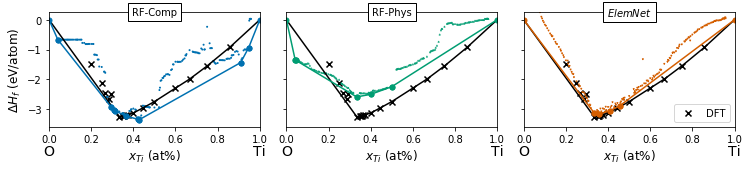

In [12]:
fig, ax = plt.subplots(1, 3, sharey=True)

# Plot the DFT convex hull
for i in range(3):
    res = ax[i].scatter(dft_TiO['X_Ti'], dft_TiO['delta_e'], marker='x', color='k', label='DFT')
    for x, y in get_hull(dft_TiO):
        ax[i].plot(x, y, 'k')
ax[2].legend(loc='lower right')

# Plot the RF convex hull
ax[0].scatter(rf_fractions_TiO['X_Ti'], rf_fractions_TiO['delta_e'], s=1,
           marker='o', color=tuple(colors["rf-comp"]), facecolor='none', label='RF-Fractions')
for x, y in get_hull(rf_fractions_TiO):
    ax[0].plot(x, y, '.-', color=colors["rf-comp"], ms=10)
ax[0].text(0.5, 1, 'RF-Comp', transform=ax[0].transAxes,
          ha='center', va='center', bbox={'facecolor': 'w', 'edgecolor': 'k'})
    
# Plot the RF convex hull
ax[1].scatter(rf_physical_TiO['X_Ti'], rf_physical_TiO['delta_e'], s=1,
           marker='^', color=colors["rf-phys"], facecolor='none', label='RF-Physical')
for x, y in get_hull(rf_physical_TiO):
    ax[1].plot(x, y, '.-', color=colors["rf-phys"], ms=10)
ax[1].text(0.5, 1, 'RF-Phys', transform=ax[1].transAxes,
          ha='center', va='center', bbox={'facecolor': 'w', 'edgecolor': 'k'})
    
# Plot the RF convex hull
ax[2].scatter(dl_TiO['X_Ti'], dl_TiO['delta_e'], s=1,
           marker='v', color=colors["elemnet"], facecolor='none', label='DL')
for x, y in get_hull(dl_TiO):
    ax[2].plot(x, y, '.-', color=colors["elemnet"], ms=10)
ax[2].text(0.5, 1, '$ElemNet$', transform=ax[2].transAxes,
          ha='center', va='center', bbox={'facecolor': 'w', 'edgecolor': 'k'})
    

for i in range(3):
    ax[i].text(0, -0.25, 'O', fontsize=14, ha='center', transform=ax[i].transAxes)
    ax[i].set_xlabel('$x_{Ti}$ (at%)', fontsize=12)
    ax[i].set_xlim(0,1)
    ax[i].text(1, -0.25, 'Ti', fontsize=14, ha='center', transform=ax[i].transAxes)
ax[0].set_ylabel('$\Delta H_f$ (eV/atom)', fontsize=12)

ax[0].set_ylim(min(ax[0].get_ylim()), 0.25)
fig.set_size_inches(figure_width * 3, figure_height)

fig.tight_layout()
fig.savefig(os.path.join('figures', 'TiO-binary.png'), dpi=320)
fig.savefig(os.path.join('figures', 'TiO-binary.pdf'))

## Make a ternary plot
Plot one of the ternaries in the Na-Fe-Mn-O leave-out test

### Read the data

In [13]:
dft_data = pd.read_csv(os.path.join('datasets', 'NaFeMnO_test_set-fractions.csv'))

In [14]:
rf_fractions_data = pd.read_csv(os.path.join('model-outputs', 'RF_NaFeMnO_search-space-fractions.csv'))

In [15]:
rf_physical_data = pd.read_csv(os.path.join('model-outputs', 'RF_NaFeMnO_search-space-physical.csv'))
rf_physical_data = rf_physical_data.join(rf_fractions_data.drop('delta_e', 'columns'))
rf_physical_data['delta_e'] = rf_physical_data['Class']

In [16]:
dl_data = pd.read_csv(os.path.join('model-outputs', 'NaFeMnO_search-space.csv'))

### Make the plot

In [17]:
dft_NaMnO = dft_data[np.isclose(dft_data[['X_Na', 'X_Mn', 'X_O']].sum(axis=1), 1)]

In [18]:
rf_fractions_NaMnO = rf_fractions_data[np.isclose(rf_fractions_data[['X_Na', 'X_Mn', 'X_O']].sum(axis=1), 1)].query(
    ' and '.join(['X_%s > 0'%x for x in ['Mn', 'Na', 'O']]))

In [19]:
rf_physical_NaMnO = rf_physical_data[np.isclose(rf_fractions_data[['X_Na', 'X_Mn', 'X_O']].sum(axis=1), 1)].query(
    ' or '.join(['X_%s > 0'%x for x in ['Mn', 'Na', 'O']]))

In [20]:
dl_NaMnO = dl_data[np.isclose(dl_data[['X_Na', 'X_Mn', 'X_O']].sum(axis=1), 1)].query(
    ' or '.join(['X_%s > 0'%x for x in ['Mn', 'Na', 'O']]))

In [21]:
def get_hull(data):
    """Get the plot points for the Ti-O binary convex hull"""
    # Generate the points
    hull_points = data[['X_Na', 'X_Mn', 'delta_e']].query('delta_e < 0').values.tolist()
    original_len = len(hull_points)
    hull_points.extend([[0,0,0],[0,1,0],[1,0,0]])
    hull_points = np.array(hull_points)
    
    # Compute the convex hull
    hull = ConvexHull(hull_points)
    
    # Return the coordinate of the plot
    plot_points = []
    for simplex in hull.simplices:
        if all([x >= original_len for x in simplex]):
            continue # This is the [0,1] point
        x = np.append(hull_points[simplex, 0], hull_points[simplex[0], 0])
        y = np.append(hull_points[simplex, 1], hull_points[simplex[0], 1])
        plot_points.append([x, y])
        
    return plot_points

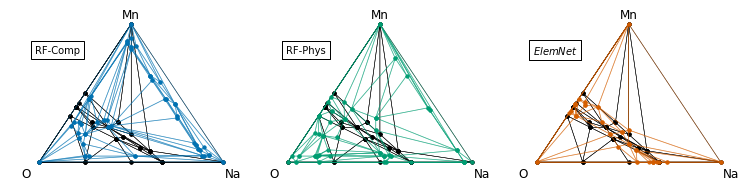

In [22]:
fig, ax = plt.subplots(1, 3)

# Plot the DFT convex hull
for i in range(3):
    fig, tax = ternary.figure(scale=1, ax=ax[i])
    for x, y in get_hull(dft_NaMnO):
        xs, ys = ternary.helpers.project_sequence(zip(x,y))
        dft_h, = ax[i].plot(xs, ys, 'k.-', lw=0.5)

# Plot the RF convex hull
for x, y in get_hull(rf_fractions_NaMnO):
    xs, ys = ternary.helpers.project_sequence(zip(x,y))
    rf_f_h, = ax[0].plot(xs, ys, 'b.-', color=colors["rf-comp"], alpha=0.5, lw=0.75)
ax[0].text(0.1, 0.7, 'RF-Comp',
          ha='center', va='center', bbox={'facecolor': 'w', 'edgecolor': 'k'})
    
# Plot the RF+physics convex hull
for x, y in get_hull(rf_physical_NaMnO):
    xs, ys = ternary.helpers.project_sequence(zip(x,y))
    rf_f_h, = ax[1].plot(xs, ys, 'r.-', color=colors["rf-phys"], alpha=0.5, lw=0.75)
    ax[1].text(0.1, 0.7, 'RF-Phys',
          ha='center', va='center', bbox={'facecolor': 'w', 'edgecolor': 'k'})

# Plot the RF+physics convex hull
for x, y in get_hull(dl_NaMnO):
    xs, ys = ternary.helpers.project_sequence(zip(x,y))
    rf_f_h, = ax[2].plot(xs, ys, 'g.-', color=colors["elemnet"], alpha=0.5, lw=0.75)
    ax[2].text(0.1, 0.7, '$ElemNet$',
          ha='center', va='center', bbox={'facecolor': 'w', 'edgecolor': 'k'})

    
# Make it pretty
for a in ax:
    a.axis('off')
    a.set_xlim([-0.05, 1.10])
    a.set_ylim([-0.05, 1.10 * 3 ** 0.5 / 2])
    a.text(1.10, -.10, 'Na', ha='right', fontsize=12) # 1st elem
    a.text(.50, .90, 'Mn', ha='center', fontsize=12) # 2nd elem
    a.text(-.10, -.10, 'O', ha='left', fontsize=12) # 3rd elem

fig.set_size_inches(figure_width * 3, figure_width * 0.8)

fig.tight_layout()
fig.savefig(os.path.join('figures', 'NaMnO-ternary.png'), dpi=320)
fig.savefig(os.path.join('figures', 'NaMnO-ternary.pdf'))